In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

In [2]:
from triangle_counter.helpers import run_experiment

In [17]:
from numba import jit

@jit
def brute_force_algorithm(g: nx.Graph) -> int:
    """
    Brute force method, test all possible 3-cycles.
    """
    num_triangles = 0
    n = len(g.nodes)

    # O(n^3) in total
    for node_a in range(n): # order n
        for node_b in range(node_a, n): # ~order n
            for node_c in range(node_b, n): # order n
                if g.has_edge(node_a, node_b) and g.has_edge(node_b, node_c) and g.has_edge(node_c, node_a):
                    num_triangles += 1

    return num_triangles

@jit
def alternative_approach(g: nx.Graph) -> int:
    num_triangles = 0
    n = len(g.nodes)

    # worst case is O(n^3) with fully connected network
    # otherwise O(n*k_mean^2) where k_mean is average degree of each node
    for node_a in range(n):  # this step is order n
        # for each node get the its neighbors (assumes this is constant look up time)
        node_a_neighbors  = list(g.neighbors(node_a))
        for idx, node_b in enumerate(node_a_neighbors):
            for node_c in node_a_neighbors[idx:]:
                if g.has_edge(node_a, node_b) and g.has_edge(node_b, node_c) and g.has_edge(node_c, node_a):
                    num_triangles += 1

    return num_triangles


In [23]:
eval_graph_sizes = np.linspace(100, 300, 25, dtype=int)
num_sims = 5
probability_of_edge_creation = 0.25 # for the E-R graph generator 

brute_force_results = run_experiment(brute_force_algorithm, eval_graph_sizes, num_sims, prob_of_edge_creation=probability_of_edge_creation)
alternative_results = run_experiment(alternative_approach, eval_graph_sizes, num_sims, prob_of_edge_creation=probability_of_edge_creation)
brute_force_results = pd.DataFrame(brute_force_results, columns=["n", "run_time"]).set_index("n")
alternative_results = pd.DataFrame(alternative_results, columns=["n", "run_time"]).set_index("n")

In [24]:
# fit polynomial estimators for each algorithm
coefs_bf = np.polyfit(eval_graph_sizes, brute_force_results["run_time"], deg=3) # brute force is O(n^3)
p_bf = np.poly1d(coefs_bf)
print("Brute Force has estimated polynomial run time: " + " + ".join([f"{val:.2f}*n^{idx}" for idx, val in enumerate(coefs_bf)]))

k = eval_graph_sizes * probability_of_edge_creation  # average number of degrees for a node in graph
root_n_k = np.sqrt(eval_graph_sizes) * k
coefs_alternative = np.polyfit(root_n_k, alternative_results["run_time"], deg=2) # this approach is O(nk^2)
p_alternative = np.poly1d(coefs_alternative)
print("Alternative Approach has estimated polynomial run time: " + " + ".join([f"{val:.2f}*(sqrt(n)k)^{idx}" for idx, val in enumerate(coefs_alternative)]))

Brute Force has estimated polynomial run time: -0.00*n^0 + 0.00*n^1 + -0.06*n^2 + 4.20*n^3
Alternative Approach has estimated polynomial run time: 0.00*(sqrt(n)k)^0 + 0.00*(sqrt(n)k)^1 + 0.49*(sqrt(n)k)^2


Text(0, 0.5, 'Average runtime, seconds.')

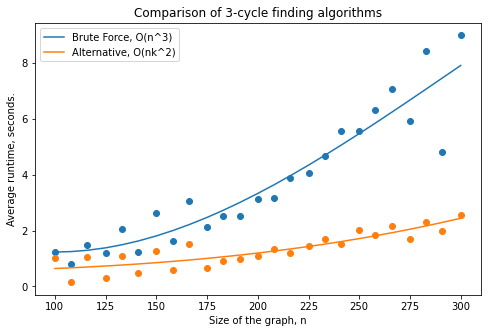

In [25]:
f, ax = plt.subplots(1,1, figsize=(8,5))

ax.scatter(eval_graph_sizes, brute_force_results["run_time"])
ax.scatter(eval_graph_sizes, alternative_results["run_time"])
ax.plot(eval_graph_sizes, p_bf(eval_graph_sizes))
ax.plot(eval_graph_sizes, p_alternative(root_n_k))
ax.legend(["Brute Force, O(n^3)", "Alternative, O(nk^2)"])
ax.set_title("Comparison of 3-cycle finding algorithms")
ax.set_xlabel("Size of the graph, n")
ax.set_ylabel("Average runtime, seconds.")